# Iris Dataset Analysis with Linear Regression in Java

This notebook demonstrates how to perform data analysis and build a linear regression model using the Iris dataset with Java. We'll use DFLib (a DataFrame library for Java) along with our custom glue libraries that make working with data in Java more intuitive.

## Setup and Dependencies

First, let's import the required libraries. We're using:
1. DFLib - for DataFrame operations
2. DFLib CSV - for reading CSV files
3. JFreeChart - for data visualization

Our custom glue libraries provide simplified interfaces to these libraries.

In [1]:
%maven org.dflib:dflib-jupyter:2.0.0-M2
%maven org.dflib:dflib-csv:2.0.0-M2
%maven org.jfree:jfreechart:1.5.5

In [2]:
// Import our DFLib glue library and DFLib classes
import org.jjavaglue.dflib.DS;
import org.dflib.*;
import org.dflib.series.*;

// Import our core utilities and DFLib glue library
import static org.jjavaglue.core.J.*;

// Import Java standard libraries
import java.util.*;
import java.io.*;
import java.nio.file.*;

## Loading the Dataset

We'll load the famous Iris dataset, which contains measurements of 150 iris flowers from three different species. The dataset includes sepal length, sepal width, petal length, petal width, and species name.

In [3]:
// Load the iris dataset from the CSV file
DataFrame irisDf = DS.read(getDataPath("Iris.csv"));

// Display first few rows
println("Iris Dataset Preview:");
DS.show(irisDf, 10);

Iris Dataset Preview:

Id SepalLengthCm SepalWidthCm PetalLengthCm PetalWidthCm Species    
-- ------------- ------------ ------------- ------------ -----------
1  5.1           3.5          1.4           0.2          Iris-setosa
2  4.9           3.0          1.4           0.2          Iris-setosa
3  4.7           3.2          1.3           0.2          Iris-setosa
...
8  5.0           3.4          1.5           0.2          Iris-setosa
9  4.4           2.9          1.4           0.2          Iris-setosa
10 4.9           3.1          1.5           0.1          Iris-setosa
10 rows x 6 columns
... 140 more rows


## Exploring the Dataset

Let's examine the dataset to understand its structure and contents. We'll look at:
- Basic information about the DataFrame
- The first few rows of data
- Dataset dimensions
- Distribution of different species

In [4]:
// Show basic information about the dataframe
println("\nDataset Information:");
DS.describe(irisDf);


Dataset Information:
DataFrame: 6 columns × 150 rows

Columns:
  Id                   ArraySeries          Sample: [1, 2, 3]
  SepalLengthCm        ArraySeries          Sample: [5.1, 4.9, 4.7]
  SepalWidthCm         ArraySeries          Sample: [3.5, 3.0, 3.2]
  PetalLengthCm        ArraySeries          Sample: [1.4, 1.4, 1.3]
  PetalWidthCm         ArraySeries          Sample: [0.2, 0.2, 0.2]
  Species              ArraySeries          Sample: [Iris-setosa, Iris-setosa, Iris-setosa]

First 5 rows:

Id SepalLengthCm SepalWidthCm PetalLengthCm PetalWidthCm Species    
-- ------------- ------------ ------------- ------------ -----------
1  5.1           3.5          1.4           0.2          Iris-setosa
2  4.9           3.0          1.4           0.2          Iris-setosa
3  4.7           3.2          1.3           0.2          Iris-setosa
4  4.6           3.1          1.5           0.2          Iris-setosa
5  5.0           3.6          1.4           0.2          Iris-setosa
5 rows x 6 

In [5]:
// Overview of Iris Data

// Show dimensions of the DataFrame
printf("Dataset shape: %d rows x %d columns%n", irisDf.height(), irisDf.width());

Dataset shape: 150 rows x 6 columns


In [6]:
// Count species distribution
println("\nSpecies Distribution:");
GroupBy groupedBySpecies = irisDf.group(Hasher.of("Species"));

for (var key : groupedBySpecies.getGroupKeys()) {
    DataFrame group = groupedBySpecies.getGroup(key);
    printf("%s: %d samples%n", key, group.height());
}


Species Distribution:
Iris-setosa: 50 samples
Iris-versicolor: 50 samples
Iris-virginica: 50 samples


## Data Visualization

Visualizing data helps us understand patterns and relationships. Let's create scatter plots to see how different features relate to each other, and how well they separate the different iris species.

In [7]:
// Import JFreeChart plotting utilities
import org.jjavaglue.jfreechart.Plots;
import org.jjavaglue.jfreechart.ChartDisplay;
import static org.jjavaglue.core.J.*;

// Set the plotting style to match ggplot
Plots.style("ggplot");

### Scatter Plot: Sepal Dimensions

This plot shows the relationship between sepal length and sepal width for each iris species. Different colors represent different species.

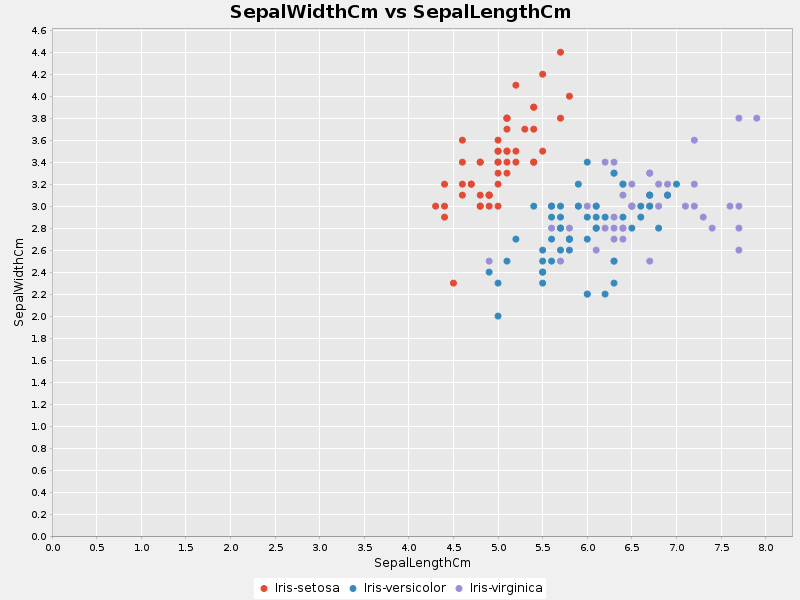

In [8]:
// Create a scatter plot of sepal dimensions
var sepalScatter = Plots.scatter(irisDf, "SepalLengthCm", "SepalWidthCm", "Species");
ChartDisplay.toImage(sepalScatter);

### Scatter Plot: Petal Dimensions

This plot shows the relationship between petal length and petal width for each iris species. Notice how well-separated the species are in this feature space compared to the sepal dimensions.

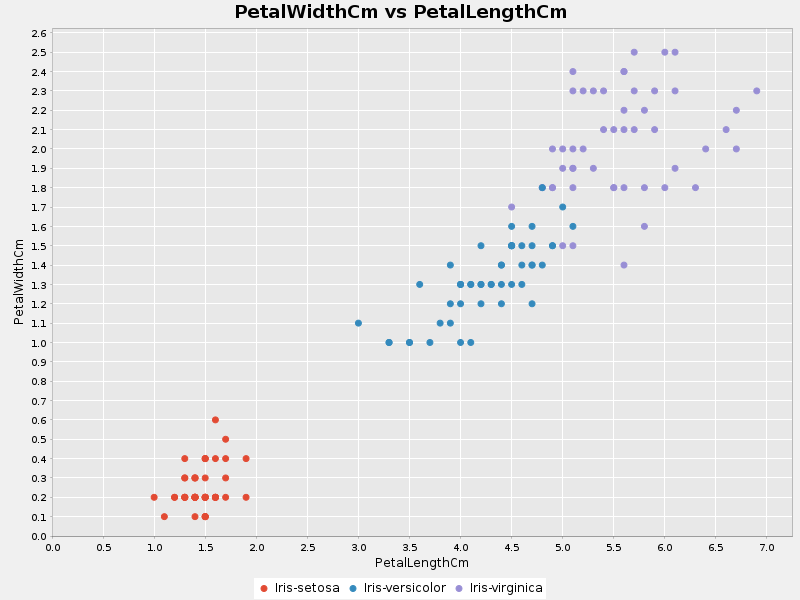

In [9]:
// Create a scatter plot of petal dimensions
var petalScatter = Plots.scatter(irisDf, "PetalLengthCm", "PetalWidthCm", "Species");
ChartDisplay.toImage(petalScatter);

### Histogram of Sepal Length

A histogram shows the distribution of a single feature. Here we can see how sepal length is distributed across all samples.

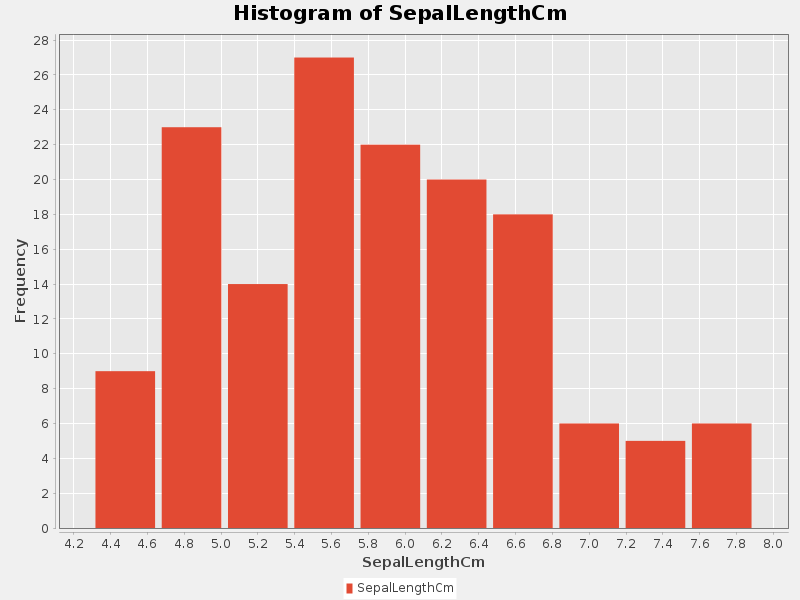

In [10]:
// Create a histogram of sepal length
var sepalHist = Plots.histogram(irisDf, "SepalLengthCm");
ChartDisplay.toImage(sepalHist);

### Pairplot

A pairplot shows relationships between all pairs of features, with histograms along the diagonal. This gives us a comprehensive view of the dataset.

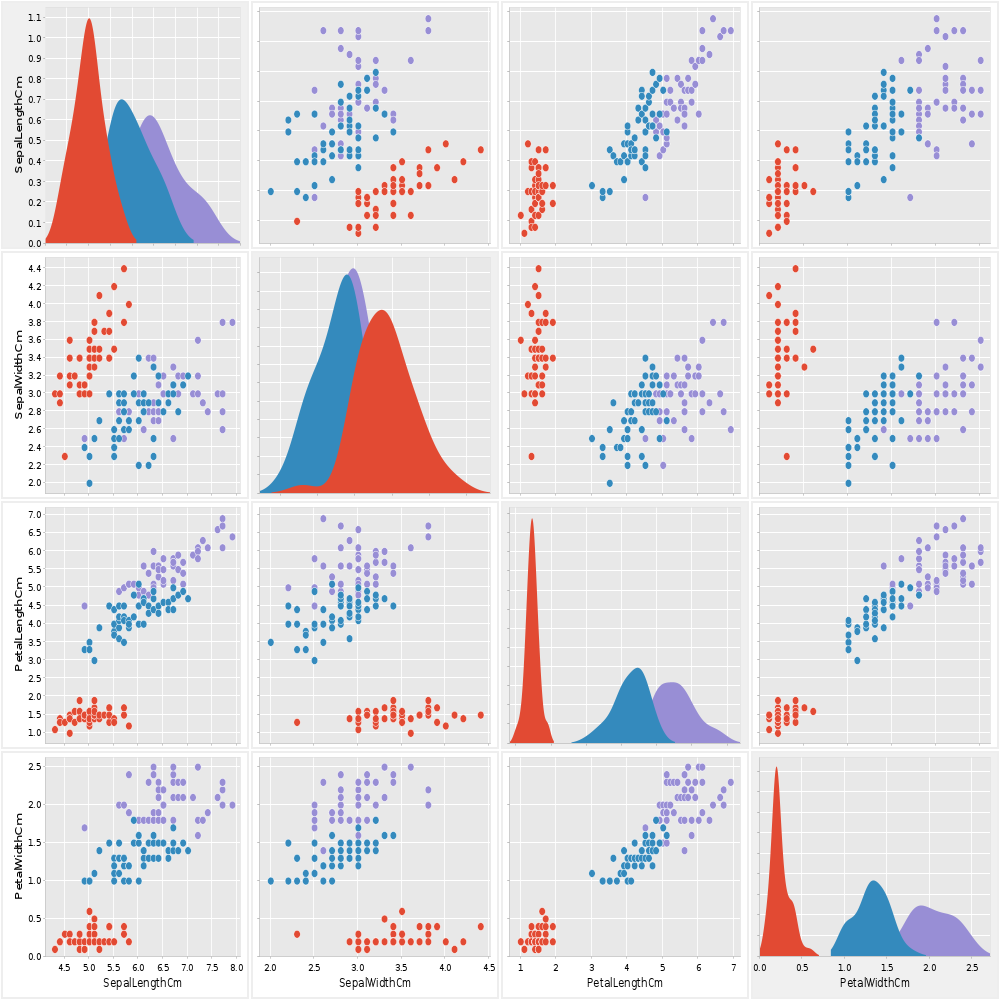

In [11]:
// Create a pairplot (similar to seaborn's pairplot)
var pairplot = Plots.pairplot(irisDf, "Species",
                          "SepalLengthCm", "SepalWidthCm",
                          "PetalLengthCm", "PetalWidthCm");

// Use the specialized pairplot rendering method
ChartDisplay.toPairplotImage(pairplot, 1000, 1000);

## Data Preprocessing

Before building our model, we need to prepare the data. We'll:
1. Convert categorical species names to numeric values
2. Split the data into features (X) and target (y)
3. Split the data into training and test sets

In [12]:
import org.jjavaglue.math.ML;
import org.jjavaglue.math.Model;
import org.jjavaglue.math.Metrics;
import org.dflib.Exp;

In [13]:
// Using select with an expression
var dfWithNumericSpecies = irisDf.cols("Species").merge(
    Exp.$col("Species").mapVal(species -> 
        switch ((String) species) {
            case "Iris-setosa" -> 0;
            case "Iris-versicolor" -> 1;
            case "Iris-virginica" -> 2;
            default -> -1;
        }
    )
);

// Preview the data with numeric species
println("DataFrame with numeric species:");
DS.show(dfWithNumericSpecies, 5);

DataFrame with numeric species:

Id SepalLengthCm SepalWidthCm PetalLengthCm PetalWidthCm Species
-- ------------- ------------ ------------- ------------ -------
1  5.1           3.5          1.4           0.2                0
2  4.9           3.0          1.4           0.2                0
3  4.7           3.2          1.3           0.2                0
4  4.6           3.1          1.5           0.2                0
5  5.0           3.6          1.4           0.2                0
5 rows x 6 columns
... 145 more rows


In [14]:
// Problem: Predict sepal length (cm)
Object[] splitData = ML.splitTarget(dfWithNumericSpecies, "SepalLengthCm");
DataFrame X = (DataFrame) splitData[0]; // Features
Series<?> y = (Series<?>) splitData[1];  // Target

// Preview features and target
println("Features (X) preview:");
DS.show(X, 5);

// Display first 5 target values using a different approach
System.out.print("\nTarget (y) preview: [");
for (int i = 0; i < Math.min(5, y.size()); i++) {
    System.out.print(y.get(i));
    if (i < Math.min(4, y.size() - 1)) {
        System.out.print(", ");
    }
}
System.out.println("]");

Features (X) preview:

Id SepalWidthCm PetalLengthCm PetalWidthCm Species
-- ------------ ------------- ------------ -------
1  3.5          1.4           0.2                0
2  3.0          1.4           0.2                0
3  3.2          1.3           0.2                0
4  3.1          1.5           0.2                0
5  3.6          1.4           0.2                0
5 rows x 5 columns
... 145 more rows

5.1, 4.9, 4.7, 4.6, 5.0]


In [15]:
// Split into training and test sets (67% train, 33% test)
ML.TrainTestSplit split = ML.trainTestSplit(X, y, 0.33, 101);

// Print the sizes without using printf
System.out.println("Training set size: " + split.xTrain.height() + " samples");
System.out.println("Test set size: " + split.xTest.height() + " samples");

Training set size: 100 samples
Test set size: 50 samples


In [16]:
// Debug information
System.out.println("xTrain dimensions: " + split.xTrain.height() + " rows × " + split.xTrain.width() + " columns");
System.out.println("yTrain length: " + split.yTrain.size() + " elements");

System.out.println("\nColumn names:");
for (String colName : split.xTrain.getColumnsIndex()) {
    System.out.println(" - " + colName);
}

xTrain dimensions: 100 rows × 5 columns
yTrain length: 100 elements

Column names:
 - Id
 - SepalWidthCm
 - PetalLengthCm
 - PetalWidthCm
 - Species


## Building a Linear Regression Model

Now, let's build a linear regression model to predict sepal length based on the other features. We'll:
1. Fit the model on the training data
2. Examine the model coefficients
3. Make predictions on the test data

In [17]:
// Instantiate the LinearRegression model
Model lr = ML.linearRegression();

// Fit the model
lr.fit(split.xTrain, split.yTrain);

// Model summary
println(lr.summary());

Linear Regression Model
----------------------
Formula: y = 1.9435 - 0.0012 * Id + 0.6121 * SepalWidthCm + 0.6909 * PetalLengthCm - 0.2254 * PetalWidthCm - 0.1862 * Species

R²: 0.8689
Adjusted R²: 0.8620
Residual Standard Error: 0.3120


## Model Evaluation

Finally, we'll evaluate our model using various metrics:
- Mean Absolute Error (MAE)
- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)
- R² Score

These metrics help us understand how well our model is performing.

In [18]:
// Predict on test set
double[] predictions = lr.predict(split.xTest);

// Display first few predictions vs actual values
println("Predictions vs Actual Values:");
for (int i = 0; i < 5; i++) {
    printf("Predicted: %.2f, Actual: %s%n", predictions[i], split.yTest.get(i));
}

Predictions vs Actual Values:
Predicted: 5.73, Actual: 5.8
Predicted: 6.59, Actual: 7.0
Predicted: 6.70, Actual: 6.4
Predicted: 5.45, Actual: 5.7
Predicted: 6.08, Actual: 5.9


In [19]:
// Calculate performance metrics
double mae = Metrics.mae(split.yTest, predictions);
double mse = Metrics.mse(split.yTest, predictions);
double rmse = Metrics.rmse(split.yTest, predictions);
double r2 = Metrics.r2(split.yTest, predictions);

println("\nModel Performance:");
printf("Mean Absolute Error: %.4f%n", mae);
printf("Mean Squared Error: %.4f%n", mse);
printf("Root Mean Squared Error: %.4f%n", rmse);
printf("R² Score: %.4f%n", r2);


Model Performance:
Mean Absolute Error: 0.2517
Mean Squared Error: 0.1051
Root Mean Squared Error: 0.3243
R² Score: 0.8356


## Conclusion

In this notebook, we've:
1. Loaded and explored the Iris dataset
2. Visualized relationships between features
3. Built a linear regression model to predict sepal length
4. Evaluated the model's performance

This demonstrates how Java can be used effectively for data science tasks with the right libraries and utilities.